# A simple baseline CNN with improvements
Our baseline CNN has an accuracy of around 77%. Let's see if we can improve! We will test the following:
1. Data augmentation
2. Balance dataset
3. Dropout
4. Batch normalization
5. 

## import required libraries


In [1]:
import os
import sys
import torch
import torch.optim as optim
from torchinfo import summary


module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_train_transforms, get_val_transforms
from src.models import simplecnn
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix, plot_learningrate


## 1. Add data augmentation (accuracy 89%, + 13%)

In the previous notebook (03_simple_CNN.ipynb) we explored a simple CNN and trained it on the original dataset. The results showed that the model overfitted the original training dataset. To prevent this overfitting, lets try data augmentation.
 Data augmentation creates new training examples through applying small modifications to the original training images. Examples of such modifications are cropping, rotation, or flipping. Data augnmentation helps in similating slight variability in real world data, so that the model is able to generalize better on unseen data.

Data augmentation should only be applied to the training dataset and not to the validation and test set, because during validation and testing, we want to measure performance on data that resembles unaltered, realistic inputs.

In Pytorch, defining a dataset using torchvision.transforms, the augmentation is applied each time an image is loaded during training. Every epoch (and every batch) the model sees slightly different versions of the same training images. Thus, when the augmentation is applied, the number of training samples per epoch stays the same (namely the number of images in the original, un-augmented training set), but the model sees a slightly different version of each image every time it is loaded. As a result, the model sees more variety over multiple epochs. 

### Configuration
Set hyperparameters and device for training. Use GPU if available, otherwise use the CPU

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 10
learning_rate = 0.001
img_size = 224 # make smaller for faster CPU training
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"


### Load data
Here we apply the data augmentation to the train dataset by setting augment to 'True' when retreiving the train transform. The data augmentation consists of the following steps:
- RandomHorizontalFlip(p=0.5): randomly flip the image with 50% probability. This represents variations in patient position
- RandomRotation(10): Randomly rotate the image in the range -10 to 10 degrees. This represents slight positioning differences during scanning.
- RandomResizedCrop(size,scale=(0.9,0.1)): randomply crop the image and resize it. This represents variablity in cropping or zooming level.
- ColorJitter(brightness=0.1, contrast=0.1): This represents variability in image acquisition, like exposure and contrast.

In [3]:
# set num_workers to 0, safer on Windows with CPU
train_transform = get_train_transforms(img_size,augment=True) # apply data augmentation
val_transform = get_val_transforms(img_size)
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

### Model setup
#### Create instance of SimpleCNN model 

In [ ]:
model_augment = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=False, use_dropout=False)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model_augment.parameters(), lr=learning_rate)

# print the model summary
summary(model_augment,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-7                  [32, 64, 56, 56]          18,496
│    │    └─ReLU: 3-8                    [32, 64, 56, 56]          --
│    │ 

### Train the model


In [5]:
metrics_history= train_model(model_augment,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [06:14<00:00,  2.30s/it]


  Average train loss:0.233753  
 Accuracy on the train dataset: 90.84%


Validation: 100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


  Average val loss:0.607367  
 Accuracy on the validation dataset: 83.97%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [04:12<00:00,  1.55s/it]


  Average train loss:0.133503  
 Accuracy on the train dataset: 95.05%


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


  Average val loss:0.345529  
 Accuracy on the validation dataset: 86.22%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [04:10<00:00,  1.54s/it]


  Average train loss:0.124214  
 Accuracy on the train dataset: 95.55%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


  Average val loss:0.358853  
 Accuracy on the validation dataset: 87.02%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [04:11<00:00,  1.54s/it]


  Average train loss:0.114854  
 Accuracy on the train dataset: 95.78%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


  Average val loss:0.499574  
 Accuracy on the validation dataset: 83.01%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [04:15<00:00,  1.57s/it]


  Average train loss:0.098657  
 Accuracy on the train dataset: 96.45%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


  Average val loss:0.291171  
 Accuracy on the validation dataset: 90.22%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [04:12<00:00,  1.55s/it]


  Average train loss:0.099408  
 Accuracy on the train dataset: 96.30%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


  Average val loss:0.416308  
 Accuracy on the validation dataset: 87.34%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [04:20<00:00,  1.60s/it]


  Average train loss:0.085014  
 Accuracy on the train dataset: 96.82%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


  Average val loss:0.299288  
 Accuracy on the validation dataset: 88.78%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [04:10<00:00,  1.53s/it]


  Average train loss:0.084828  
 Accuracy on the train dataset: 96.97%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


  Average val loss:0.317666  
 Accuracy on the validation dataset: 89.58%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [04:14<00:00,  1.56s/it]


  Average train loss:0.071472  
 Accuracy on the train dataset: 97.49%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


  Average val loss:0.273429  
 Accuracy on the validation dataset: 90.71%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [04:20<00:00,  1.60s/it]


  Average train loss:0.073973  
 Accuracy on the train dataset: 97.26%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

  Average val loss:0.289386  
 Accuracy on the validation dataset: 89.58%
Done!


### Save the model

In [7]:
torch.save(model_augment,'../models/simplecnn_dataaugment_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


Accuracy on the test set: 89.58%
Precision: 0.92, Recall: 0.92, F1 score: 0.92, AUC: 0.89
classification_report :              precision    recall  f1-score   support

           0       0.86      0.86      0.86       234
           1       0.92      0.92      0.92       390

    accuracy                           0.90       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



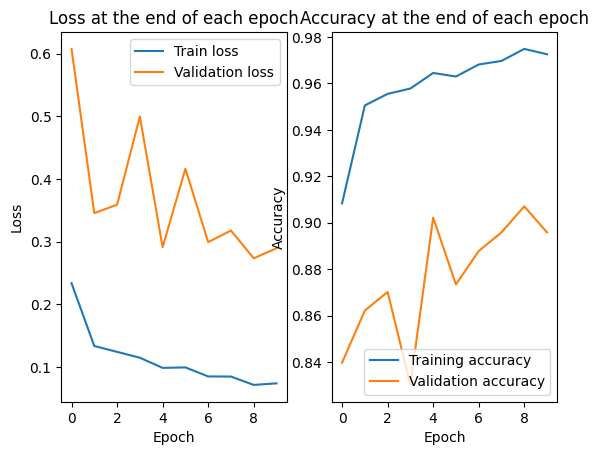

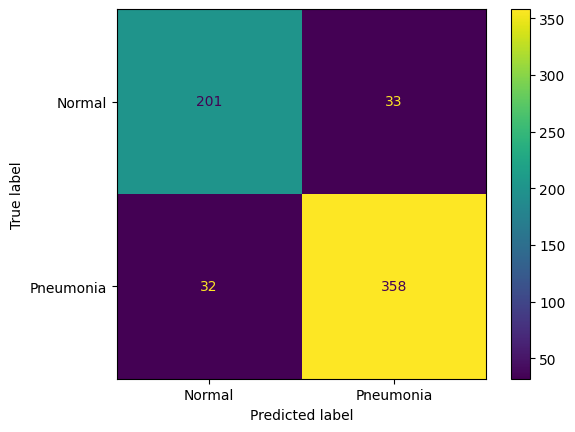

In [8]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_augment, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

### Conclusion
- Adding data augmentation to our training dataset has improved the model performance. The accuracy on the test dataset now is 89%. The F1 score is 0.92.

## 2. Balance the training dataset
The current training dataset is imbalanced, there are more pneumonia images than there are normal images. This can lead to a model that does not perform well on the under-represented class, i.e. the model becomes biased toward the majority class. This is also what we see in the confusion matrix, the model has more difficulty to correctly identify normal images (more false negatives than false positives, it predicts 'Pneumonia' too often).
Here we will use Pytorch's 'WeightedRandomSampler' to assign a higher probability to the minority class, so that both classes are seen equally during training.


### load data
Here we create a new train dataloader, that balances the dataset


In [4]:
balanced_train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform,balance=True)


### Model setup

In [ ]:
model_balance = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=False, use_dropout=False)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

# optimizer
optimizer = torch.optim.Adam(model_balance.parameters(), lr=learning_rate)

# print the model summary
summary(model_balance,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-7                  [32, 64, 56, 56]          18,496
│    │    └─ReLU: 3-8                    [32, 64, 56, 56]          --
│    │ 

### Train the model

In [11]:
metrics_history= train_model(model_balance,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [04:59<00:00,  1.84s/it]


  Average train loss:0.316915  
 Accuracy on the train dataset: 85.56%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


  Average val loss:0.338865  
 Accuracy on the validation dataset: 85.90%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [04:44<00:00,  1.74s/it]


  Average train loss:0.133077  
 Accuracy on the train dataset: 95.03%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


  Average val loss:0.458561  
 Accuracy on the validation dataset: 81.73%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [04:34<00:00,  1.68s/it]


  Average train loss:0.145693  
 Accuracy on the train dataset: 94.19%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


  Average val loss:0.392531  
 Accuracy on the validation dataset: 86.38%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [04:47<00:00,  1.77s/it]


  Average train loss:0.112218  
 Accuracy on the train dataset: 95.86%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


  Average val loss:0.412269  
 Accuracy on the validation dataset: 85.42%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [04:47<00:00,  1.76s/it]


  Average train loss:0.101795  
 Accuracy on the train dataset: 95.88%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


  Average val loss:0.365989  
 Accuracy on the validation dataset: 86.70%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [04:51<00:00,  1.79s/it]


  Average train loss:0.086663  
 Accuracy on the train dataset: 96.63%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


  Average val loss:0.362755  
 Accuracy on the validation dataset: 87.02%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [04:46<00:00,  1.76s/it]


  Average train loss:0.090650  
 Accuracy on the train dataset: 96.53%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


  Average val loss:0.376498  
 Accuracy on the validation dataset: 86.86%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [04:42<00:00,  1.73s/it]


  Average train loss:0.078869  
 Accuracy on the train dataset: 97.11%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


  Average val loss:0.307651  
 Accuracy on the validation dataset: 88.46%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [04:44<00:00,  1.75s/it]


  Average train loss:0.073401  
 Accuracy on the train dataset: 97.24%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


  Average val loss:0.475790  
 Accuracy on the validation dataset: 84.94%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [04:43<00:00,  1.74s/it]


  Average train loss:0.076568  
 Accuracy on the train dataset: 97.24%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]

  Average val loss:0.492820  
 Accuracy on the validation dataset: 83.97%
Done!


### Save the model

In [12]:
torch.save(model_balance,'../models/simplecnn_balanced_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Accuracy on the test set: 83.97%
Precision: 0.81, Recall: 0.98, F1 score: 0.88, AUC: 0.79
classification_report :              precision    recall  f1-score   support

           0       0.94      0.61      0.74       234
           1       0.81      0.98      0.88       390

    accuracy                           0.84       624
   macro avg       0.87      0.79      0.81       624
weighted avg       0.86      0.84      0.83       624



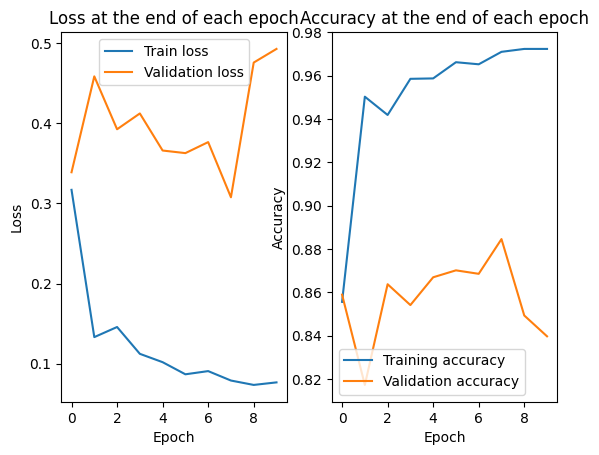

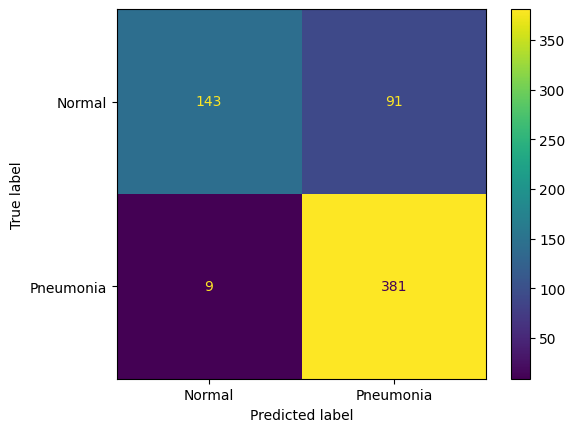

In [13]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_balance, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

## 3. Add Dropout
Dropout is a regularization technique used in deep learning models to improve generalization and prevent overfitting, especially used in CNN's. During training, a dropout layer randomly 'drops', or deactivates, a portion of the neuron's in the layer it's applied to. For example, if the dropout rate is set to 0.2, then 20% of the neurons in that layer are randomly ignored during each training step. This way, the network is prevented to rely too heavily on specific neurons, promoting redundancy and making the model more robust.

So, lets try to add a dropout layer right after the last convolutional layer, before entering the fully connected layer. And let's set the dropout rate to 0.5

### Model setup

In [ ]:
model_dropout = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=False, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=learning_rate)

# print the model summary
summary(model_dropout,input_size=[batch_size,n_channels,img_size,img_size])


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─ReLU: 3-2                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-3               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 32, 112, 112]        4,640
│    │    └─ReLU: 3-5                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-6               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └─Conv2d: 3-7                  [32, 64, 56, 56]          18,496
│    │    └─ReLU: 3-8                    [32, 64, 56, 56]          --
│    │ 

### Train the model

In [6]:
metrics_history = train_model(model_dropout,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [04:55<00:00,  1.81s/it]


  Average train loss:0.297850  
 Accuracy on the train dataset: 87.10%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


  Average val loss:0.357788  
 Accuracy on the validation dataset: 85.26%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [04:38<00:00,  1.71s/it]


  Average train loss:0.182811  
 Accuracy on the train dataset: 92.87%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


  Average val loss:0.338020  
 Accuracy on the validation dataset: 87.82%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [04:41<00:00,  1.73s/it]


  Average train loss:0.148951  
 Accuracy on the train dataset: 94.17%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


  Average val loss:0.467330  
 Accuracy on the validation dataset: 83.65%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [04:38<00:00,  1.71s/it]


  Average train loss:0.137932  
 Accuracy on the train dataset: 94.71%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


  Average val loss:0.324203  
 Accuracy on the validation dataset: 86.06%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [04:42<00:00,  1.73s/it]


  Average train loss:0.132783  
 Accuracy on the train dataset: 95.13%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


  Average val loss:0.274360  
 Accuracy on the validation dataset: 87.82%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [04:43<00:00,  1.74s/it]


  Average train loss:0.109420  
 Accuracy on the train dataset: 96.18%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


  Average val loss:0.292320  
 Accuracy on the validation dataset: 89.10%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [04:42<00:00,  1.73s/it]


  Average train loss:0.113339  
 Accuracy on the train dataset: 96.01%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


  Average val loss:0.368839  
 Accuracy on the validation dataset: 86.70%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [04:39<00:00,  1.72s/it]


  Average train loss:0.101177  
 Accuracy on the train dataset: 96.40%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


  Average val loss:0.340245  
 Accuracy on the validation dataset: 88.46%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [04:41<00:00,  1.73s/it]


  Average train loss:0.112094  
 Accuracy on the train dataset: 96.13%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


  Average val loss:0.356199  
 Accuracy on the validation dataset: 87.18%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [04:39<00:00,  1.71s/it]


  Average train loss:0.096818  
 Accuracy on the train dataset: 96.89%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]

  Average val loss:0.355299  
 Accuracy on the validation dataset: 86.22%
Done!


### Save the model

In [7]:
torch.save(model_dropout,'../models/simplecnn_dropout_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Accuracy on the test set: 86.22%
Precision: 0.83, Recall: 0.98, F1 score: 0.90, AUC: 0.82
classification_report :              precision    recall  f1-score   support

           0       0.95      0.67      0.78       234
           1       0.83      0.98      0.90       390

    accuracy                           0.86       624
   macro avg       0.89      0.82      0.84       624
weighted avg       0.88      0.86      0.86       624



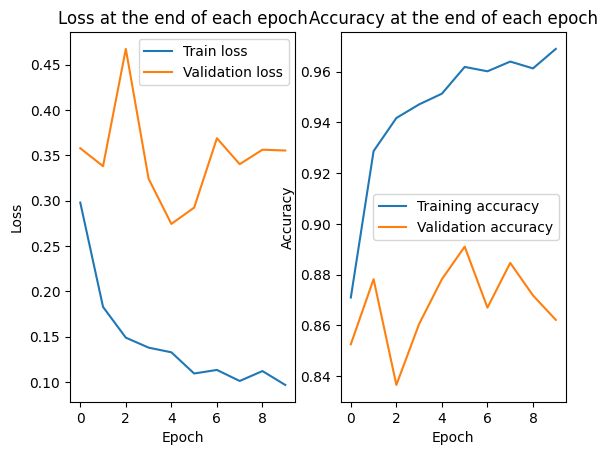

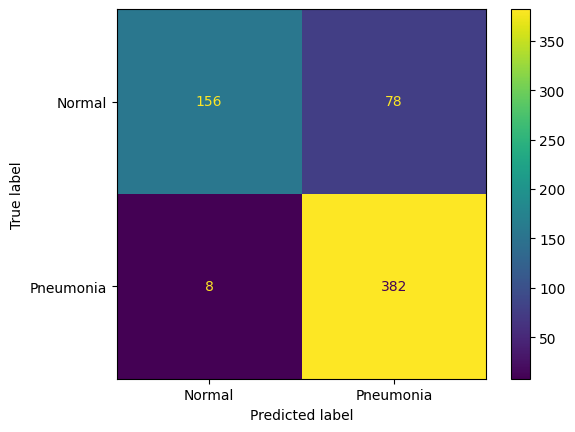

In [8]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_dropout, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])


## 3. Add batch normalization
Deep networks can experience internal convariance shift. This means that the distribution of inputs to each layer changes during training, which forces the network to constantly adapt, and this can slow down training. Batch normalization normalizes the inputs to each layer, which ensures a more stable and faster convergence. Batchnormalization works best when it is placed after a convulutional layer but before the activation function. This allows the network to stabilize its inputs while still allowing the non-linear transformation to take place effectively.
Let's see if batchnormalization can improve our relatively simple model!

### Model setup

In [ ]:
model_batchnorm = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model_batchnorm.parameters(), lr=learning_rate)

# print the model summary
summary(model_batchnorm,input_size=[batch_size,n_channels,img_size,img_size])


Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─BatchNorm2d: 3-2             [32, 16, 224, 224]        32
│    │    └─ReLU: 3-3                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-4               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 32, 112, 112]        4,640
│    │    └─BatchNorm2d: 3-6             [32, 32, 112, 112]        64
│    │    └─ReLU: 3-7                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └

### Train the model


In [11]:
metrics_history = train_model(model_batchnorm,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [06:01<00:00,  2.22s/it]


  Average train loss:0.597902  
 Accuracy on the train dataset: 87.62%


Validation: 100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


  Average val loss:0.316630  
 Accuracy on the validation dataset: 87.02%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [05:35<00:00,  2.06s/it]


  Average train loss:0.199159  
 Accuracy on the train dataset: 92.64%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


  Average val loss:0.305874  
 Accuracy on the validation dataset: 87.02%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [05:26<00:00,  2.00s/it]


  Average train loss:0.175536  
 Accuracy on the train dataset: 93.87%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


  Average val loss:0.290171  
 Accuracy on the validation dataset: 87.34%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [05:22<00:00,  1.98s/it]


  Average train loss:0.158174  
 Accuracy on the train dataset: 94.56%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


  Average val loss:0.470244  
 Accuracy on the validation dataset: 83.97%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [05:15<00:00,  1.93s/it]


  Average train loss:0.164724  
 Accuracy on the train dataset: 93.94%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.20it/s]


  Average val loss:0.341271  
 Accuracy on the validation dataset: 88.94%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [05:15<00:00,  1.94s/it]


  Average train loss:0.158157  
 Accuracy on the train dataset: 94.31%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


  Average val loss:0.303509  
 Accuracy on the validation dataset: 87.18%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [05:11<00:00,  1.91s/it]


  Average train loss:0.146509  
 Accuracy on the train dataset: 94.56%


Validation: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


  Average val loss:0.331946  
 Accuracy on the validation dataset: 88.14%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [05:13<00:00,  1.93s/it]


  Average train loss:0.139239  
 Accuracy on the train dataset: 95.05%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


  Average val loss:0.349952  
 Accuracy on the validation dataset: 88.94%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [05:21<00:00,  1.98s/it]


  Average train loss:0.138782  
 Accuracy on the train dataset: 94.98%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


  Average val loss:0.376468  
 Accuracy on the validation dataset: 87.02%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [05:15<00:00,  1.93s/it]


  Average train loss:0.147940  
 Accuracy on the train dataset: 95.00%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]

  Average val loss:0.343603  
 Accuracy on the validation dataset: 88.14%
Done!


### Save the model

In [12]:
torch.save(model_batchnorm,'../models/simplecnn_batchnorm_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Accuracy on the test set: 88.14%
Precision: 0.87, Recall: 0.96, F1 score: 0.91, AUC: 0.86
classification_report :              precision    recall  f1-score   support

           0       0.92      0.75      0.83       234
           1       0.87      0.96      0.91       390

    accuracy                           0.88       624
   macro avg       0.89      0.86      0.87       624
weighted avg       0.88      0.88      0.88       624



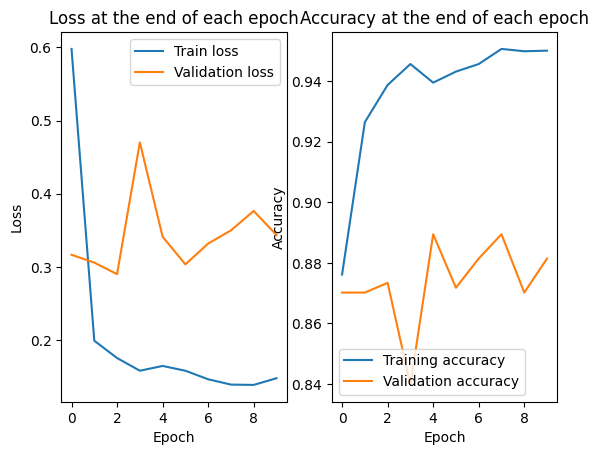

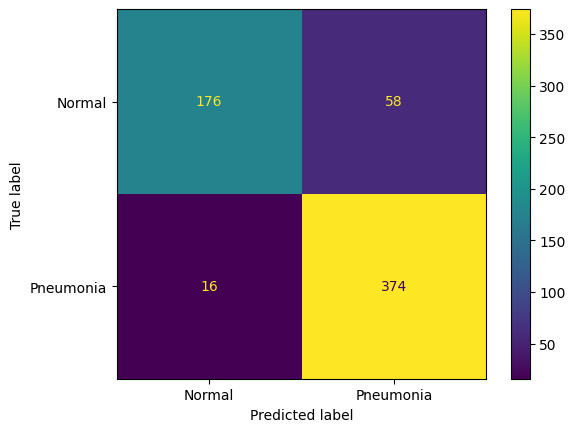

In [13]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_batchnorm, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

## 4. Add weight decay (L2)
This penalizes larger weights in the model, thereby applying regularization. Weight decay is implemented via the weight_decay parameter in the optimizer
### model setup

In [ ]:
### model setup
model_weightdecay = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weight decay
optimizer = torch.optim.Adam(model_weightdecay.parameters(), lr=learning_rate,weight_decay=1e-4)

# print the model summary
summary(model_weightdecay,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─BatchNorm2d: 3-2             [32, 16, 224, 224]        32
│    │    └─ReLU: 3-3                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-4               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 32, 112, 112]        4,640
│    │    └─BatchNorm2d: 3-6             [32, 32, 112, 112]        64
│    │    └─ReLU: 3-7                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └

In [15]:
metrics_history = train_model(model_weightdecay,balanced_train_dataloader,test_dataloader,optimizer, loss_function,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [05:11<00:00,  1.91s/it]


  Average train loss:0.640183  
 Accuracy on the train dataset: 85.93%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


  Average val loss:0.313225  
 Accuracy on the validation dataset: 88.30%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [05:13<00:00,  1.92s/it]


  Average train loss:0.206211  
 Accuracy on the train dataset: 92.54%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


  Average val loss:0.287036  
 Accuracy on the validation dataset: 87.66%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [05:17<00:00,  1.95s/it]


  Average train loss:0.188974  
 Accuracy on the train dataset: 93.35%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


  Average val loss:0.308531  
 Accuracy on the validation dataset: 88.30%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [05:15<00:00,  1.94s/it]


  Average train loss:0.173691  
 Accuracy on the train dataset: 93.50%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


  Average val loss:0.282199  
 Accuracy on the validation dataset: 89.10%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [05:48<00:00,  2.14s/it]


  Average train loss:0.141948  
 Accuracy on the train dataset: 95.07%


Validation: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


  Average val loss:0.339773  
 Accuracy on the validation dataset: 87.66%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [05:09<00:00,  1.90s/it]


  Average train loss:0.146260  
 Accuracy on the train dataset: 94.80%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


  Average val loss:0.299390  
 Accuracy on the validation dataset: 87.34%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [05:15<00:00,  1.94s/it]


  Average train loss:0.132617  
 Accuracy on the train dataset: 94.86%


Validation: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


  Average val loss:0.395906  
 Accuracy on the validation dataset: 86.22%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [05:17<00:00,  1.95s/it]


  Average train loss:0.125905  
 Accuracy on the train dataset: 95.19%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


  Average val loss:0.299866  
 Accuracy on the validation dataset: 88.46%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [05:16<00:00,  1.94s/it]


  Average train loss:0.147819  
 Accuracy on the train dataset: 94.40%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


  Average val loss:0.298815  
 Accuracy on the validation dataset: 86.86%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [05:17<00:00,  1.95s/it]


  Average train loss:0.144101  
 Accuracy on the train dataset: 95.09%


Validation: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]

  Average val loss:0.364330  
 Accuracy on the validation dataset: 86.38%
Done!


### Save the model

In [16]:
torch.save(model_weightdecay,'../models/simplecnn_weightdecay_10ep.pth')

### Results

Validation: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


Accuracy on the test set: 86.38%
Precision: 0.85, Recall: 0.95, F1 score: 0.90, AUC: 0.83
classification_report :              precision    recall  f1-score   support

           0       0.90      0.72      0.80       234
           1       0.85      0.95      0.90       390

    accuracy                           0.86       624
   macro avg       0.87      0.83      0.85       624
weighted avg       0.87      0.86      0.86       624



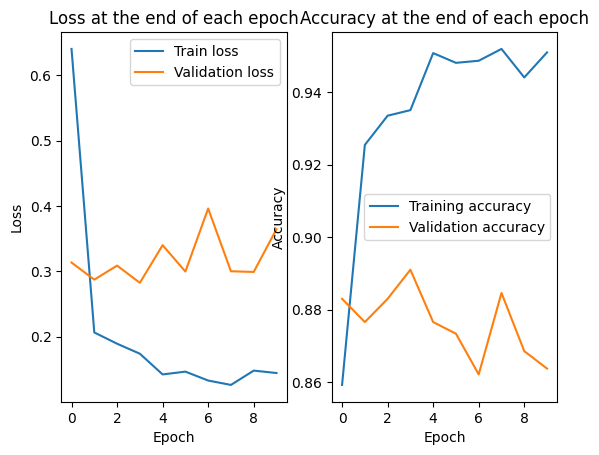

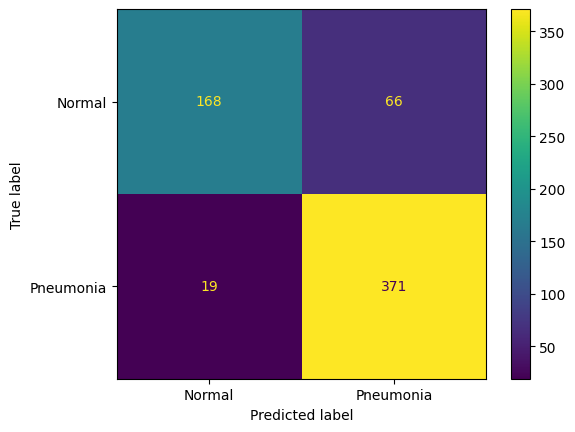

In [18]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_weightdecay, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])

## 6. Learning rate scheduler
A learing rate scheduler can be used to dynamically adjust the learning rate during training. The learning rate will be large early in the training, while it will decrease later in the training to achieve a fine fit.
Here we use Pytorch's CosineAnnealingLR scheduler, which adjusts the learning rate following a cosine curve. This scheduler enables a smooth transition between high and low learning rates throughout the training.

### Model setup

In [ ]:
model_scheduler = simplecnn.get_simplecnn(img_size,n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weight decay
optimizer = torch.optim.Adam(model_scheduler.parameters(), lr=learning_rate,weight_decay=1e-4)

# scheduler 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=learning_rate*0.1)
# print the model summary
summary(model_scheduler,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 1]                   --
├─Sequential: 1-1                        [32, 64, 28, 28]          --
│    └─Sequential: 2-1                   [32, 16, 112, 112]        --
│    │    └─Conv2d: 3-1                  [32, 16, 224, 224]        160
│    │    └─BatchNorm2d: 3-2             [32, 16, 224, 224]        32
│    │    └─ReLU: 3-3                    [32, 16, 224, 224]        --
│    │    └─MaxPool2d: 3-4               [32, 16, 112, 112]        --
│    └─Sequential: 2-2                   [32, 32, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 32, 112, 112]        4,640
│    │    └─BatchNorm2d: 3-6             [32, 32, 112, 112]        64
│    │    └─ReLU: 3-7                    [32, 32, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 32, 56, 56]          --
│    └─Sequential: 2-3                   [32, 64, 28, 28]          --
│    │    └

### Train the model

In [6]:
metrics_history = train_model(model_scheduler,balanced_train_dataloader,test_dataloader,optimizer, loss_function,scheduler,device,epochs)

TypeError: to() received an invalid combination of arguments - got (CosineAnnealingLR), but expected one of:
 * (torch.device device = None, torch.dtype dtype = None, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (torch.dtype dtype, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)
 * (Tensor tensor, bool non_blocking = False, bool copy = False, *, torch.memory_format memory_format = None)


### Save the model

In [ ]:
torch.save(model_scheduler,'../models/simplecnn_scheduler_10ep.pth')

Validation: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Accuracy on the test set: 87.34%
Precision: 0.92, Recall: 0.87, F1 score: 0.90, AUC: 0.87
classification_report :              precision    recall  f1-score   support

           0       0.81      0.87      0.84       234
           1       0.92      0.87      0.90       390

    accuracy                           0.87       624
   macro avg       0.86      0.87      0.87       624
weighted avg       0.88      0.87      0.87       624



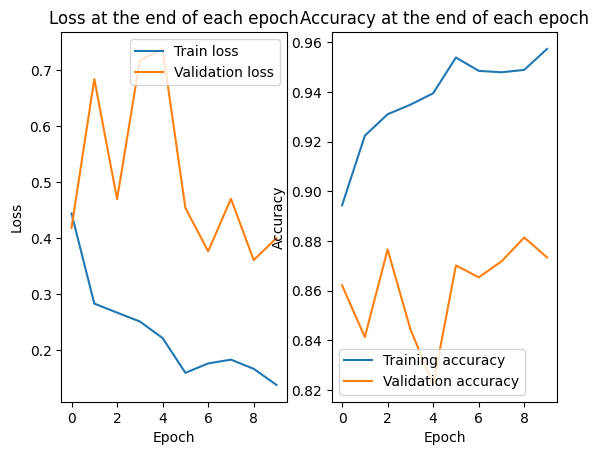

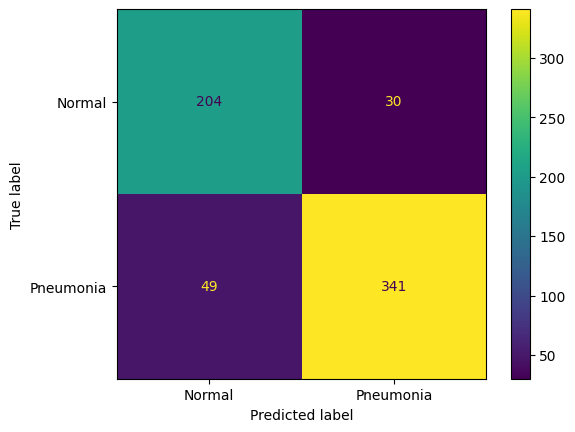

In [ ]:
plot_learningcurve(metrics_history)

plot_learningrate(metrics_history['lrs'])

eval_metrics = evaluate_model(model_scheduler, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])


## 7. Reduce model size by global average pooling
Our simple CNN already has few layers but another possibility to further reduce complexity is to replease the fully connected layer at the end of our model (Flatten -> Linear) with global average poolding layer + a linear layer (Linear(64,1)). This reduces the number of parameters 
### Model setup

In [ ]:
model_reduced = simplecnn.get_simplecnnreduced(n_channels,use_batchnorm=True, use_dropout=True,dropout_prob=0.5)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weight decay
optimizer = torch.optim.Adam(model_reduced.parameters(), lr=learning_rate,weight_decay=1e-4)

# scheduler 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=learning_rate*0.1)
# print the model summary
summary(model_reduced,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
TinyCNN                                  [32, 1]                   --
├─Sequential: 1-1                        [32, 16, 56, 56]          --
│    └─Sequential: 2-1                   [32, 8, 112, 112]         --
│    │    └─Conv2d: 3-1                  [32, 8, 224, 224]         80
│    │    └─BatchNorm2d: 3-2             [32, 8, 224, 224]         16
│    │    └─ReLU: 3-3                    [32, 8, 224, 224]         --
│    │    └─MaxPool2d: 3-4               [32, 8, 112, 112]         --
│    └─Sequential: 2-2                   [32, 16, 56, 56]          --
│    │    └─Conv2d: 3-5                  [32, 16, 112, 112]        1,168
│    │    └─BatchNorm2d: 3-6             [32, 16, 112, 112]        32
│    │    └─ReLU: 3-7                    [32, 16, 112, 112]        --
│    │    └─MaxPool2d: 3-8               [32, 16, 56, 56]          --
├─Sequential: 1-2                        [32, 1]                   --
│    └─Adapt

### Train model

In [6]:
metrics_history = train_model(model_reduced,balanced_train_dataloader,test_dataloader,optimizer, loss_function,scheduler,device,epochs)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [04:15<00:00,  1.57s/it]


  Average train loss:0.615671  
 Accuracy on the train dataset: 69.11%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


  Average val loss:0.598323  
 Accuracy on the validation dataset: 76.44%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [04:21<00:00,  1.60s/it]


  Average train loss:0.557874  
 Accuracy on the train dataset: 74.31%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


  Average val loss:0.588507  
 Accuracy on the validation dataset: 75.48%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [04:21<00:00,  1.60s/it]


  Average train loss:0.541434  
 Accuracy on the train dataset: 74.19%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


  Average val loss:0.557742  
 Accuracy on the validation dataset: 76.28%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [04:05<00:00,  1.51s/it]


  Average train loss:0.548593  
 Accuracy on the train dataset: 72.97%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


  Average val loss:0.544626  
 Accuracy on the validation dataset: 75.32%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [04:03<00:00,  1.49s/it]


  Average train loss:0.534258  
 Accuracy on the train dataset: 74.39%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.52it/s]


  Average val loss:0.539305  
 Accuracy on the validation dataset: 77.56%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [04:03<00:00,  1.49s/it]


  Average train loss:0.520988  
 Accuracy on the train dataset: 75.67%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


  Average val loss:0.520048  
 Accuracy on the validation dataset: 78.04%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [04:07<00:00,  1.52s/it]


  Average train loss:0.512327  
 Accuracy on the train dataset: 75.54%


Validation: 100%|██████████| 20/20 [00:12<00:00,  1.54it/s]


  Average val loss:0.533507  
 Accuracy on the validation dataset: 77.24%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [04:03<00:00,  1.49s/it]


  Average train loss:0.517843  
 Accuracy on the train dataset: 75.52%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.49it/s]


  Average val loss:0.534870  
 Accuracy on the validation dataset: 77.40%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [03:58<00:00,  1.46s/it]


  Average train loss:0.511518  
 Accuracy on the train dataset: 76.09%


Validation: 100%|██████████| 20/20 [00:12<00:00,  1.57it/s]


  Average val loss:0.533275  
 Accuracy on the validation dataset: 76.12%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [04:01<00:00,  1.48s/it]


  Average train loss:0.504581  
 Accuracy on the train dataset: 76.46%


Validation: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]

  Average val loss:0.524244  
 Accuracy on the validation dataset: 78.21%
Done!


### Save the model

In [ ]:
torch.save(model_reduced,'../models/simplecnn_reduced_10ep.tph')

Validation: 100%|██████████| 20/20 [00:13<00:00,  1.48it/s]


Accuracy on the test set: 78.21%
Precision: 0.85, Recall: 0.79, F1 score: 0.82, AUC: 0.78
classification_report :              precision    recall  f1-score   support

           0       0.69      0.76      0.72       234
           1       0.85      0.79      0.82       390

    accuracy                           0.78       624
   macro avg       0.77      0.78      0.77       624
weighted avg       0.79      0.78      0.78       624



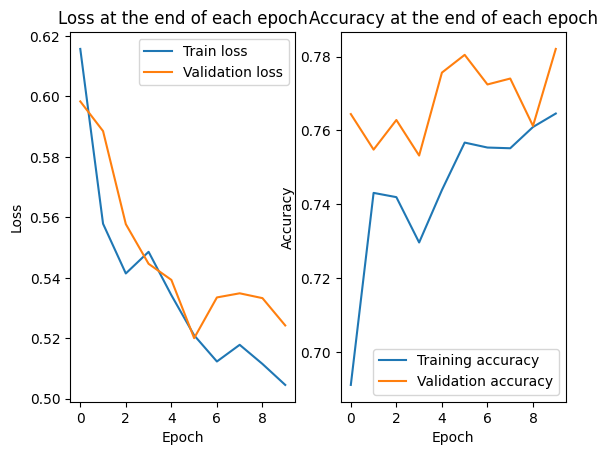

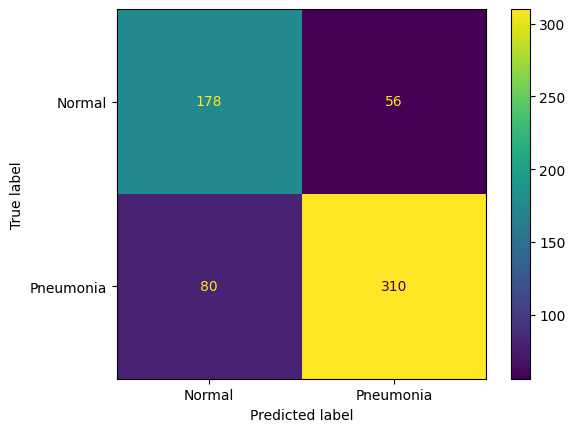

In [7]:
plot_learningcurve(metrics_history)

eval_metrics = evaluate_model(model_reduced, test_dataloader, loss_function, device="cpu")
       
    
print(f"Accuracy on the test set: {eval_metrics['accuracy']:.2%}")

print(f"Precision: {eval_metrics['precision']:.2f}, Recall: {eval_metrics['recall']:.2f}, F1 score: {eval_metrics['f1']:.2f}, AUC: {eval_metrics['auc']:.2f}")

print(f'classification_report :{eval_metrics['classification report']}')
# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics['confusion matrix'])